In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils import np_utils
from keras.layers import TextVectorization
import keras.layers as l
import tensorflow as tf
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath

from keras.models import Sequential

def split_dataset(df):
    train, test, ytrain, ytest = train_test_split(df['item_name'], df['category'], test_size=0.2, random_state=88)

    return train, test, ytrain, ytest
    

def create_one_hot_labels(Y_train, Y_test, labels):
    encoder = LabelEncoder()
    encoder.fit(labels)

    Y_train = encoder.transform(Y_train)
    Y_test = encoder.transform(Y_test)

    n_classes = np.max(Y_train) + 1

    Y_train = np_utils.to_categorical(Y_train, n_classes)
    Y_test = np_utils.to_categorical(Y_test, n_classes)

    return Y_train, Y_test, n_classes


def get_max_len(df):
    idx = df['item_name'].str.len().idxmax()

    max_len = len(df["item_name"][idx])

    if max_len > 450:
        max_len = 500
    else:
        max_len += 50

    return max_len


def get_vectors(df, X_train, X_test, max_len):
    vectorizer = TextVectorization(output_sequence_length=max_len)

    vectorizer.adapt(df['item_name'])

    vocab = vectorizer.get_vocabulary()

    word_index = dict(zip(vocab, range(len(vocab))))

    X_train = vectorizer(X_train)
    X_test = vectorizer(X_test)

    return X_train, X_test, vocab, word_index


def get_embedding_model(matrix, n_tokens, max_len, n_classes):
    embedding_layer = l.Embedding(
    n_tokens,
    100,
    input_length=max_len,
    embeddings_initializer=tf.keras.initializers.Constant(matrix),
    trainable=True
    )

    embedding_model = Sequential()
    embedding_model.add(embedding_layer)
    embedding_model.add(l.GlobalMaxPooling1D()) # Turn 2D output into 1D for dense layers

    # embedding_model.add(l.Dense(128, activation='relu'))
    embedding_model.add(l.Dense(n_classes, activation='softmax'))

    optim = tf.keras.optimizers.Adam()

    embedding_model.compile(
        loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy']
    )

    return embedding_model


def get_model_acc(X_train, X_test, Y_train, Y_test, model):
    history = model.fit(X_train, Y_train, batch_size=2, epochs=10, validation_data=(X_test, Y_test))
    metrics = [[name, history.history['val_accuracy'][-1], history.history['val_loss'][-1]]]
    
    metrics = pd.DataFrame(metrics, columns=['variation', 'val_accuracy', 'val_loss'])
    return metrics, history


def train_ft(df):
    cor_path = datapath("lee_background.cor")
    ft = FastText(vector_size=100)

    train_ft = df['item_name'].tolist()

    train_ft = [x.split() for x in train_ft]

    ft.build_vocab(corpus_file=cor_path)

    ft.train(
    corpus_file=cor_path, epochs=ft.epochs,
    total_examples=ft.corpus_count, total_words=ft.corpus_total_words,
    )

    ft.build_vocab(train_ft, update=True)
    ft.train(train_ft, total_examples=len(train_ft), epochs=ft.epochs)

    return ft


def get_ft_matrix(vocab, word_index, ft):
    n_tokens = len(vocab) + 2
    embedding_dim = 100
    hits = 0
    misses = 0

    matrix = np.zeros((n_tokens, embedding_dim))

    for word, i in word_index.items():
        try:
            embedding_vector = ft.wv[word]

            if embedding_vector is not None:
                matrix[i] = embedding_vector
                hits += 1
            else:
                matrix[i] = np.random.randn(embedding_dim)
                misses += 1
        except Exception as e:
            matrix[i] = np.random.randn(embedding_dim)
            print(e)
            misses += 1

    print("Converted %d words (%d misses)" % (hits, misses))

    return matrix, n_tokens

Get data

In [34]:
import pandas as pd

amazon_data = pd.read_csv("../cleaned/amazon-cleaned.csv",index_col=0)
amazon_labels = amazon_data.category.unique()

shopmania_data = pd.read_csv("../cleaned/shopmania-cleaned.csv", index_col=0)
shopmania_labels = shopmania_data.category.unique()

custom_data = pd.read_csv("../cleaned/custom-cleaned.csv", names=["store_name", "item_name", "category"])
custom_labels = custom_data.category.unique()

datasets = {'amazon': [amazon_data.copy(), amazon_labels], 'shopmania': [shopmania_data.copy(), shopmania_labels], 'custom': [custom_data.copy(), custom_labels]}

In [35]:
custom_data.sample()

,store_name,item_name,category
503.0,TESCO,sausages,groceries


Models, experiments

In [36]:
from time import process_time

In [37]:
import matplotlib.pyplot as plt
def train_val_graph(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])

    plt.title(f'History of {metric} over epochs')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['training '+metric, 'validation '+metric])

    plt.show()

In [38]:
def run_ft(df, labels):

    df['item_name'] = df['item_name'].astype(str)

    X_train, X_test, Y_train, Y_test = split_dataset(df)

    Y_train, Y_test, n_classes = create_one_hot_labels(Y_train, Y_test, labels)

    max_len = get_max_len(df)

    X_train, X_test, vocab, word_index = get_vectors(df, X_train, X_test, max_len)

    ft_embeddings = train_ft(df)

    ft_matrix, n_tokens = get_ft_matrix(vocab, word_index, ft_embeddings)

    ft_model = get_embedding_model(ft_matrix, n_tokens, max_len, n_classes)
    
    metrics = get_model_acc(X_train, X_test, Y_train, Y_test, ft_model)
    
    return metrics

Converted 19893 words (0 misses)
Epoch 1/10
4000/4000 [==============================] - 9s 2ms/step - loss: 3.5686 - accuracy: 0.2250 - val_loss: 2.5081 - val_accuracy: 0.4800
Epoch 2/10
4000/4000 [==============================] - 8s 2ms/step - loss: 1.7201 - accuracy: 0.6471 - val_loss: 1.3783 - val_accuracy: 0.6875
Epoch 3/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.8748 - accuracy: 0.8101 - val_loss: 1.0195 - val_accuracy: 0.7525
Epoch 4/10
4000/4000 [==============================] - 8s 2ms/step - loss: 0.5238 - accuracy: 0.8876 - val_loss: 0.9131 - val_accuracy: 0.7695
Epoch 5/10
4000/4000 [==============================] - 8s 2ms/step - loss: 0.3318 - accuracy: 0.9315 - val_loss: 0.8341 - val_accuracy: 0.7975
Epoch 6/10
4000/4000 [==============================] - 8s 2ms/step - loss: 0.2041 - accuracy: 0.9603 - val_loss: 0.8181 - val_accuracy: 0.7910
Epoch 7/10
4000/4000 [==============================] - 8s 2ms/step - loss: 0.1231 - accuracy: 0.9761 -

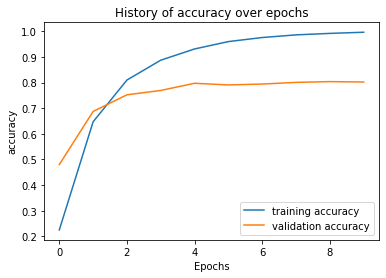

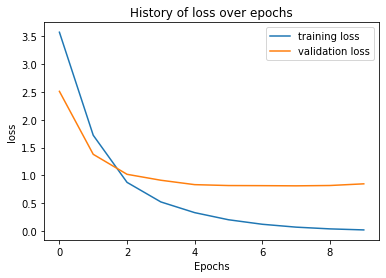

Converted 13203 words (0 misses)
Epoch 1/10
4483/4483 [==============================] - 9s 2ms/step - loss: 4.4398 - accuracy: 0.1297 - val_loss: 3.6269 - val_accuracy: 0.2770
Epoch 2/10
4483/4483 [==============================] - 9s 2ms/step - loss: 2.7654 - accuracy: 0.4841 - val_loss: 2.4357 - val_accuracy: 0.5406
Epoch 3/10
4483/4483 [==============================] - 9s 2ms/step - loss: 1.6572 - accuracy: 0.6952 - val_loss: 1.8146 - val_accuracy: 0.6418
Epoch 4/10
4483/4483 [==============================] - 9s 2ms/step - loss: 1.0105 - accuracy: 0.8160 - val_loss: 1.5162 - val_accuracy: 0.6922
Epoch 5/10
4483/4483 [==============================] - 9s 2ms/step - loss: 0.6133 - accuracy: 0.8851 - val_loss: 1.3308 - val_accuracy: 0.7230
Epoch 6/10
4483/4483 [==============================] - 9s 2ms/step - loss: 0.3650 - accuracy: 0.9316 - val_loss: 1.2379 - val_accuracy: 0.7467
Epoch 7/10
4483/4483 [==============================] - 9s 2ms/step - loss: 0.2104 - accuracy: 0.9612 -

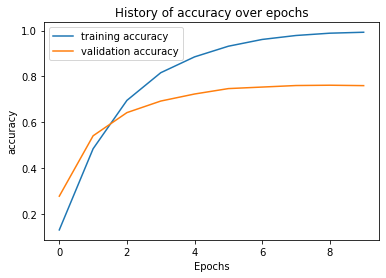

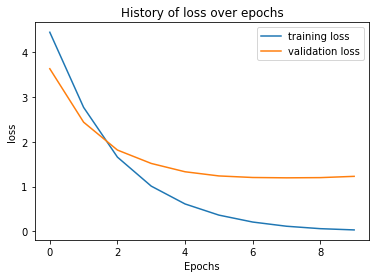

Converted 697 words (0 misses)
Epoch 1/10
264/264 [==============================] - 1s 2ms/step - loss: 2.0131 - accuracy: 0.4744 - val_loss: 1.5505 - val_accuracy: 0.5530
Epoch 2/10
264/264 [==============================] - 1s 2ms/step - loss: 1.5607 - accuracy: 0.5199 - val_loss: 1.3681 - val_accuracy: 0.6061
Epoch 3/10
264/264 [==============================] - 1s 2ms/step - loss: 1.2965 - accuracy: 0.6091 - val_loss: 1.1501 - val_accuracy: 0.7197
Epoch 4/10
264/264 [==============================] - 1s 2ms/step - loss: 1.0112 - accuracy: 0.7268 - val_loss: 0.9763 - val_accuracy: 0.7727
Epoch 5/10
264/264 [==============================] - 1s 2ms/step - loss: 0.7768 - accuracy: 0.8046 - val_loss: 0.8808 - val_accuracy: 0.7955
Epoch 6/10
264/264 [==============================] - 1s 2ms/step - loss: 0.6010 - accuracy: 0.8596 - val_loss: 0.8020 - val_accuracy: 0.7955
Epoch 7/10
264/264 [==============================] - 1s 2ms/step - loss: 0.4724 - accuracy: 0.8805 - val_loss: 0.764

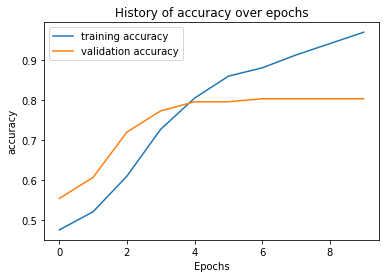

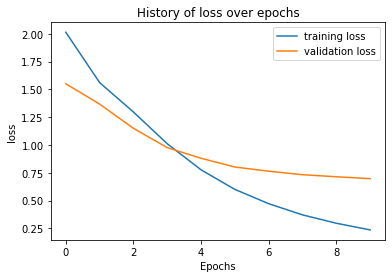

In [43]:
for key, dataset in datasets.items():
    name = key
    metrics, history = run_ft(dataset[0], dataset[1])

    train_val_graph(history, "accuracy")
    train_val_graph(history, "loss")